Scoring in next 10 actions model - Model Tuning and Building - GBM

In [1]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/")

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from exp_vaep.exp_vaep_config import exp_vaep_modelling_v2_file_path
from exp_vaep.domain.preprocessing.preprocessing import *
# from exp_vaep.domain.contracts.mappings import Mappings
from exp_vaep.domain.contracts.modelling_data_contract import ModellingDataContract
from exp_vaep.domain.modelling.hyperparameter_tuning import XGBHyperparameterTuner
from exp_vaep.domain.modelling.supermodel import SuperXGBRegressor
from exp_vaep.domain.modelling.optuna_xgb_param_grid import OptunaXGBParamGrid

pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Model Version

In [4]:
model_version = 2
model_name = 'exp_vaep_scoring'
model_file_name = model_name + '_v' + str(model_version)

model_output_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/models"
prediction_output_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/exp_vaep/model_outputs/predictions"

preprocessor_file_name = 'preprocessor_v' + str(model_version)
preprocessor_output_path = ""

In [5]:
RESPONSE = ModellingDataContract.RESPONSE_SCORES

In [6]:
FEATURES = ModellingDataContract.feature_list_scores

In [7]:
MONOTONE_CONSTRAINTS = {}

Load Data

In [8]:
df_modelling = pd.read_csv(exp_vaep_modelling_v2_file_path)
df_modelling.tail()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,xScore,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Unconteste

Train Test Split

In [9]:
training_data = df_modelling[df_modelling[RESPONSE+"TrainingSet"]]
test_data = df_modelling[df_modelling[RESPONSE+"TestSet"]]
cal_data = df_modelling[df_modelling[RESPONSE+"ValidationSet"]]

In [10]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [11]:
y_train.mean(), y_test.mean(), y_cal.mean()

(0.7900926407904131, 0.7884963794824171, 0.7944290721466609)

In [12]:
X_test.head()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,xScore,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Unconteste

Preprocess Data

In [13]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train = preprocessor.transform(X_train)
# X_test = preprocessor.transform(X_test)

In [14]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]
X_cal_preproc = X_cal[FEATURES]

In [15]:
X_train_preproc.shape, X_cal_preproc.shape, X_test_preproc.shape

((660577, 220), (165145, 220), (206431, 220))

In [16]:
X_train_preproc.head()

,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Uncontested Mark_a2,type_Contested Mark_a2,type_Loose Ball Get_a2,type_Hard Ball Get_a2,type_Spoil_a2,type_Gather_a2,type_Free For_a2,type_Knock On_a2

In [17]:
X_test_preproc.head()

,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Uncontested Mark_a2,type_Contested Mark_a2,type_Loose Ball Get_a2,type_Hard Ball Get_a2,type_Spoil_a2,type_Gather_a2,type_Free For_a2,type_Knock On_a2

<Axes: >

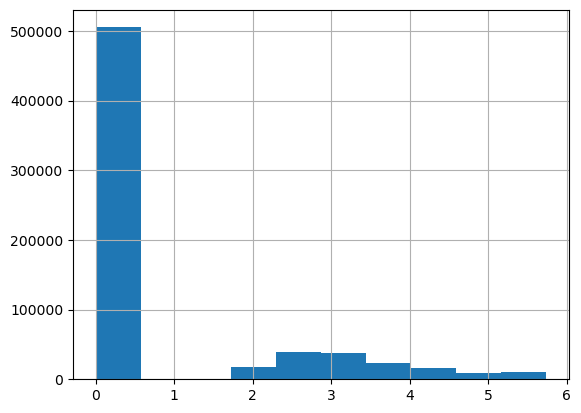

In [18]:
y_train.hist()

Optuna Hyperparameter Tuning Class - HyperParameterTuner & XGBHyperparameterTuner

In [19]:
xgb_tuner = XGBHyperparameterTuner(X_train_preproc, y_train, monotonicity_constraints={})

In [20]:
xgb_tuner.error

'reg:squarederror'

In [21]:
xgb_tuner.tune_hyperparameters()

[I 2023-09-04 13:52:30,712] A new study created in memory with name: no-name-c4861d29-11b7-49e6-8485-de820569c21d
[I 2023-09-04 13:53:05,569] Trial 0 finished with value: 1.2208688403041663 and parameters: {'max_depth': 16, 'min_child_weight': 53, 'eta': 0.4045598359549418, 'gamma': 1.4106987364604129, 'lambda': 0.0005217016426737259, 'alpha': 0.005376247089689926, 'subsample': 0.49867525344156294, 'colsample_bytree': 0.8437960395384707}. Best is trial 0 with value: 1.2208688403041663.
[I 2023-09-04 13:53:30,717] Trial 1 finished with value: 1.2280270257018844 and parameters: {'max_depth': 18, 'min_child_weight': 82, 'eta': 0.14019388853858403, 'gamma': 0.0014234460535272472, 'lambda': 0.0005078629395215934, 'alpha': 0.18378132609013892, 'subsample': 0.6447731108032999, 'colsample_bytree': 0.41866429660602056}. Best is trial 0 with value: 1.2208688403041663.
[I 2023-09-04 13:54:03,460] Trial 2 finished with value: 1.4362330568939305 and parameters: {'max_depth': 14, 'min_child_weight':

Number of finished trials:  10
Best trial:
  Value: 1.2208688403041663
  Params: 
    max_depth: 16
    min_child_weight: 53
    eta: 0.4045598359549418
    gamma: 1.4106987364604129
    lambda: 0.0005217016426737259
    alpha: 0.005376247089689926
    subsample: 0.49867525344156294
    colsample_bytree: 0.8437960395384707


In [22]:
params = xgb_tuner.get_best_params()
params

{'max_depth': 16,
 'min_child_weight': 53,
 'eta': 0.4045598359549418,
 'gamma': 1.4106987364604129,
 'lambda': 0.0005217016426737259,
 'alpha': 0.005376247089689926,
 'subsample': 0.49867525344156294,
 'colsample_bytree': 0.8437960395384707}

Training Model - SuperXGBClassifier class for training and predictions

In [23]:
params['objective'] = OptunaXGBParamGrid.error
params['num_rounds'] = 1000
params['early_stopping_rounds'] = 50
params['verbosity'] = 1
params['monotone_constraints'] = {}

In [24]:
super_xgb = SuperXGBRegressor(X_train = X_train_preproc, 
                               y_train = y_train, 
                               X_test = X_test_preproc, 
                               y_test = y_test,
                               params = params)

In [25]:
super_xgb.fit()

[0]	validation_0-rmse:1.32346	validation_1-rmse:1.32820
[1]	validation_0-rmse:1.23385	validation_1-rmse:1.24914
[2]	validation_0-rmse:1.19621	validation_1-rmse:1.22096
[3]	validation_0-rmse:1.17786	validation_1-rmse:1.21088
[4]	validation_0-rmse:1.16679	validation_1-rmse:1.20836
[5]	validation_0-rmse:1.15907	validation_1-rmse:1.20855
[6]	validation_0-rmse:1.15379	validation_1-rmse:1.21009
[7]	validation_0-rmse:1.15031	validation_1-rmse:1.21054
[8]	validation_0-rmse:1.14667	validation_1-rmse:1.21182
[9]	validation_0-rmse:1.14357	validation_1-rmse:1.21276
[10]	validation_0-rmse:1.14068	validation_1-rmse:1.21395
[11]	validation_0-rmse:1.13875	validation_1-rmse:1.21438
[12]	validation_0-rmse:1.13535	validation_1-rmse:1.21647
[13]	validation_0-rmse:1.13286	validation_1-rmse:1.21733
[14]	validation_0-rmse:1.13070	validation_1-rmse:1.21857
[15]	validation_0-rmse:1.12951	validation_1-rmse:1.21895
[16]	validation_0-rmse:1.12754	validation_1-rmse:1.21994
[17]	validation_0-rmse:1.12598	validation

In [26]:
super_xgb.xgb_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8437960395384707, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.4106987364604129, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.4045598359549418, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=53, missing=nan, monotone_constraints={},
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [27]:
super_xgb.xgb_model.get_booster().feature_names

['type_Kick_a0',
 'type_Handball_a0',
 'type_Carry_a0',
 'type_Uncontested Mark_a0',
 'type_Contested Mark_a0',
 'type_Loose Ball Get_a0',
 'type_Hard Ball Get_a0',
 'type_Spoil_a0',
 'type_Gather_a0',
 'type_Free For_a0',
 'type_Knock On_a0',
 'type_Shot_a0',
 'type_Tackle_a0',
 'type_Error_a0',
 'outcome_effective_a0',
 'outcome_ineffective_a0',
 'outcome_clanger_a0',
 'type_Kick_outcome_effective_a0',
 'type_Kick_outcome_ineffective_a0',
 'type_Kick_outcome_clanger_a0',
 'type_Handball_outcome_effective_a0',
 'type_Handball_outcome_ineffective_a0',
 'type_Handball_outcome_clanger_a0',
 'type_Carry_outcome_effective_a0',
 'type_Carry_outcome_ineffective_a0',
 'type_Carry_outcome_clanger_a0',
 'type_Uncontested Mark_outcome_effective_a0',
 'type_Uncontested Mark_outcome_ineffective_a0',
 'type_Uncontested Mark_outcome_clanger_a0',
 'type_Contested Mark_outcome_effective_a0',
 'type_Contested Mark_outcome_ineffective_a0',
 'type_Contested Mark_outcome_clanger_a0',
 'type_Loose Ball Get

In [28]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

Check Average Predictions

In [29]:
train_preds.mean(), y_train.mean()

(0.76813287, 0.7900926407904131)

In [30]:
test_preds.mean(), y_test.mean()

(0.7682187, 0.7884963794824171)

Export model

In [31]:
super_xgb.export_model(model_output_path + "/" + model_file_name + ".joblib")

Export data and predictions

In [32]:
train_export = pd.concat([X_train, y_train], axis=1)
train_export['xgb_preds_'+RESPONSE] = train_preds
train_export.to_csv(prediction_output_path + '/train_predictions_' + model_file_name + '.csv', index = False)
train_export.head()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,xScore,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Unconteste

In [33]:
test_export = pd.concat([X_test, y_test], axis=1)
test_export['xgb_preds_'+RESPONSE] = test_preds
test_export.to_csv(prediction_output_path + '/test_predictions_' + model_file_name + '.csv', index = False)
test_export.head()

,match_id,chain_number,order,quarter,quarter_seconds,overall_seconds,team,player,start_x,start_y,end_x,end_y,action_type,outcome_type,xScore,type_Kick_a0,type_Handball_a0,type_Carry_a0,type_Uncontested Mark_a0,type_Contested Mark_a0,type_Loose Ball Get_a0,type_Hard Ball Get_a0,type_Spoil_a0,type_Gather_a0,type_Free For_a0,type_Knock On_a0,type_Shot_a0,type_Tackle_a0,type_Error_a0,outcome_effective_a0,outcome_ineffective_a0,outcome_clanger_a0,type_Kick_outcome_effective_a0,type_Kick_outcome_ineffective_a0,type_Kick_outcome_clanger_a0,type_Handball_outcome_effective_a0,type_Handball_outcome_ineffective_a0,type_Handball_outcome_clanger_a0,type_Carry_outcome_effective_a0,type_Carry_outcome_ineffective_a0,type_Carry_outcome_clanger_a0,type_Uncontested Mark_outcome_effective_a0,type_Uncontested Mark_outcome_ineffective_a0,type_Uncontested Mark_outcome_clanger_a0,type_Contested Mark_outcome_effective_a0,type_Contested Mark_outcome_ineffective_a0,type_Contested Mark_outcome_clanger_a0,type_Loose Ball Get_outcome_effective_a0,type_Loose Ball Get_outcome_ineffective_a0,type_Loose Ball Get_outcome_clanger_a0,type_Hard Ball Get_outcome_effective_a0,type_Hard Ball Get_outcome_ineffective_a0,type_Hard Ball Get_outcome_clanger_a0,type_Spoil_outcome_effective_a0,type_Spoil_outcome_ineffective_a0,type_Spoil_outcome_clanger_a0,type_Gather_outcome_effective_a0,type_Gather_outcome_ineffective_a0,type_Gather_outcome_clanger_a0,type_Free For_outcome_effective_a0,type_Free For_outcome_ineffective_a0,type_Free For_outcome_clanger_a0,type_Knock On_outcome_effective_a0,type_Knock On_outcome_ineffective_a0,type_Knock On_outcome_clanger_a0,type_Shot_outcome_effective_a0,type_Shot_outcome_ineffective_a0,type_Shot_outcome_clanger_a0,type_Tackle_outcome_effective_a0,type_Tackle_outcome_ineffective_a0,type_Tackle_outcome_clanger_a0,type_Error_outcome_effective_a0,type_Error_outcome_ineffective_a0,type_Error_outcome_clanger_a0,quarter_a0,quarter_seconds_a0,overall_seconds_a0,start_x_a0,start_y_a0,end_x_a0,end_y_a0,dx_a0,dy_a0,movement_a0,type_Kick_a1,type_Handball_a1,type_Carry_a1,type_Uncontested Mark_a1,type_Contested Mark_a1,type_Loose Ball Get_a1,type_Hard Ball Get_a1,type_Spoil_a1,type_Gather_a1,type_Free For_a1,type_Knock On_a1,type_Shot_a1,type_Tackle_a1,type_Error_a1,outcome_effective_a1,outcome_ineffective_a1,outcome_clanger_a1,type_Kick_outcome_effective_a1,type_Kick_outcome_ineffective_a1,type_Kick_outcome_clanger_a1,type_Handball_outcome_effective_a1,type_Handball_outcome_ineffective_a1,type_Handball_outcome_clanger_a1,type_Carry_outcome_effective_a1,type_Carry_outcome_ineffective_a1,type_Carry_outcome_clanger_a1,type_Uncontested Mark_outcome_effective_a1,type_Uncontested Mark_outcome_ineffective_a1,type_Uncontested Mark_outcome_clanger_a1,type_Contested Mark_outcome_effective_a1,type_Contested Mark_outcome_ineffective_a1,type_Contested Mark_outcome_clanger_a1,type_Loose Ball Get_outcome_effective_a1,type_Loose Ball Get_outcome_ineffective_a1,type_Loose Ball Get_outcome_clanger_a1,type_Hard Ball Get_outcome_effective_a1,type_Hard Ball Get_outcome_ineffective_a1,type_Hard Ball Get_outcome_clanger_a1,type_Spoil_outcome_effective_a1,type_Spoil_outcome_ineffective_a1,type_Spoil_outcome_clanger_a1,type_Gather_outcome_effective_a1,type_Gather_outcome_ineffective_a1,type_Gather_outcome_clanger_a1,type_Free For_outcome_effective_a1,type_Free For_outcome_ineffective_a1,type_Free For_outcome_clanger_a1,type_Knock On_outcome_effective_a1,type_Knock On_outcome_ineffective_a1,type_Knock On_outcome_clanger_a1,type_Shot_outcome_effective_a1,type_Shot_outcome_ineffective_a1,type_Shot_outcome_clanger_a1,type_Tackle_outcome_effective_a1,type_Tackle_outcome_ineffective_a1,type_Tackle_outcome_clanger_a1,type_Error_outcome_effective_a1,type_Error_outcome_ineffective_a1,type_Error_outcome_clanger_a1,quarter_a1,quarter_seconds_a1,overall_seconds_a1,start_x_a1,start_y_a1,end_x_a1,end_y_a1,dx_a1,dy_a1,movement_a1,type_Kick_a2,type_Handball_a2,type_Carry_a2,type_Unconteste

Save preprocessor

In [ ]:
# joblib.dump(preprocessor, preprocessor_output_path + preprocessor_file_name + ".joblib")